## 导入相关包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 读取数据（训练数据前10000行，测试数据前100条）

In [2]:
# train_data = pd.read_csv('train_all.csv',nrows=10000)
# test_data = pd.read_csv('test_all.csv',nrows=100)

## 读取全部数据

In [3]:
train_data = pd.read_csv('train_all.csv',nrows=None)
test_data = pd.read_csv('test_all.csv',nrows=None)

## 获取训练和测试数据

In [4]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns]
test = test_data[features_columns]
target =train_data['label'].values

## 缺失值补全

处理缺失值有很多方法，最常用为以下几种：
1. 删除。当数据量较大时，或者缺失数据占比较小时，可以使用这种方法。
2. 填充。通用的方法是采用平均数、中位数来填充，可以适用插值或者模型预测的方法进行缺失补全。
3. 不处理。树类模型对缺失值不明感。

#### 采用中值进行填充

In [5]:
# from sklearn.preprocessing import Imputer
#
# imputer = Imputer(strategy="median")
# imputer = imputer.fit(train)
# train_imputer = imputer.transform(train)
# test_imputer = imputer.transform(test)

### 基于树模型特征选择
树模型基于分裂评价标准所计算的总的评分作为依据进行相关排序，然后进行特征筛选

In [6]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
#
# clf = ExtraTreesClassifier(n_estimators=50)
# clf = clf.fit(train, target)
#
# model = SelectFromModel(clf, prefit=True)
# train_sel = model.transform(train)
# test_sel = model.transform(test)
# print('训练数据未特征筛选维度', train.shape)
# print('训练数据特征筛选维度后', train_sel.shape)

#### 树特征重要性

In [7]:
# clf.feature_importances_[:10]

### 特征选择前后区别

In [8]:
# feature_selection(train, train_sel, target)

### Lgb特征重要性

In [9]:
import lightgbm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train,feature_name=features_columns)
test_matrix = clf.Dataset(X_test, label=y_test,feature_name=features_columns,reference=train_matrix)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2020,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, 
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)

e:\python38\lib\site-packages\lightgbm\basic.py:840: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


[1]	valid_0's multi_logloss: 0.230085
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.229843
[3]	valid_0's multi_logloss: 0.229514
[4]	valid_0's multi_logloss: 0.229205
[5]	valid_0's multi_logloss: 0.22893
[6]	valid_0's multi_logloss: 0.228666
[7]	valid_0's multi_logloss: 0.228425
[8]	valid_0's multi_logloss: 0.228197
[9]	valid_0's multi_logloss: 0.227981
[10]	valid_0's multi_logloss: 0.227839
[11]	valid_0's multi_logloss: 0.227661
[12]	valid_0's multi_logloss: 0.227481
[13]	valid_0's multi_logloss: 0.227368
[14]	valid_0's multi_logloss: 0.227249
[15]	valid_0's multi_logloss: 0.227098
[16]	valid_0's multi_logloss: 0.227007
[17]	valid_0's multi_logloss: 0.226877
[18]	valid_0's multi_logloss: 0.226749
[19]	valid_0's multi_logloss: 0.226632
[20]	valid_0's multi_logloss: 0.226519
[21]	valid_0's multi_logloss: 0.226409
[22]	valid_0's multi_logloss: 0.226303
[23]	valid_0's multi_logloss: 0.226234
[24]	valid_0's multi_logloss: 0.22615
[25]	valid_0'

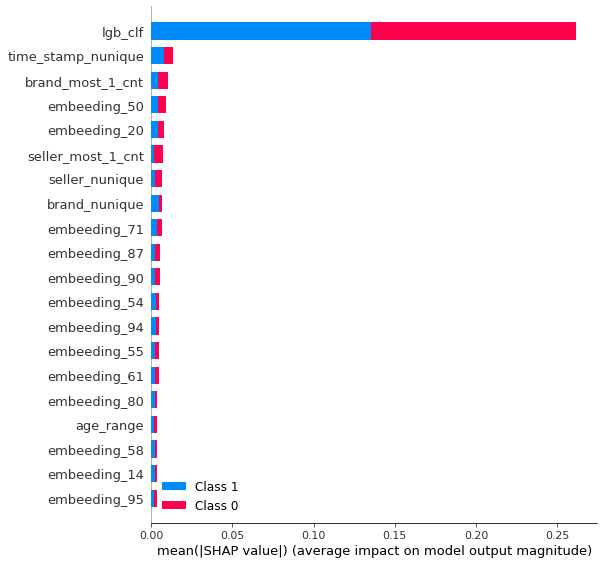

In [10]:
import shap
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('SHAPbar.tif', bbox_inches='tight',format='tiff', dpi=400)

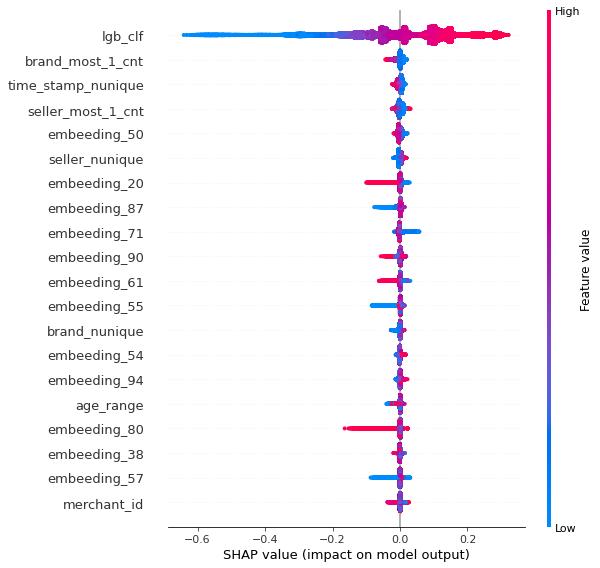

In [11]:
# shap.summary_plot(shap_values[0], X_test)
# plt.savefig('SHAPClass0.tif', bbox_inches='tight',format='tiff', dpi=200)
shap.summary_plot(shap_values[0], X_test, show=False)
plt.savefig('SHAPClass0.tif', dpi=400, bbox_inches='tight')

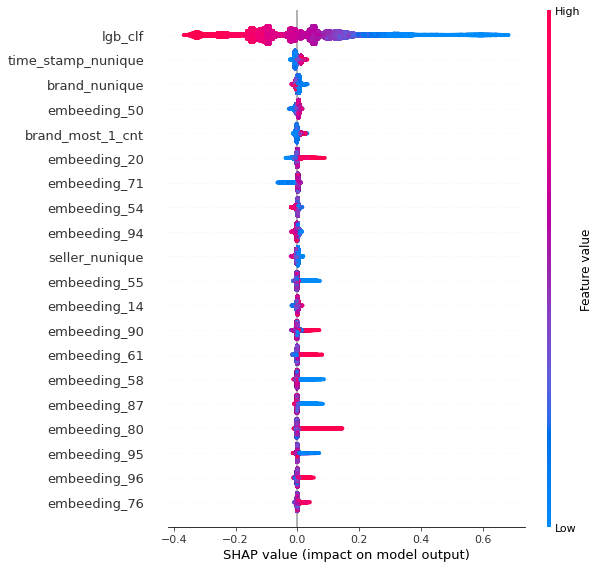

In [12]:
# shap.summary_plot(shap_values[1], X_test)
# plt.savefig('SHAPClass1.tif', bbox_inches='tight',format='tiff', dpi=200)
shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig('SHAPClass1.tif', dpi=400, bbox_inches='tight')

In [13]:
shap_sum = np.abs(shap_values[1]).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
# importance_df = importance_df.sort_values('shap_importance', ascending=False).head(20)
importance_df

,column_name,shap_importance
227,lgb_clf,0.135107
8,time_stamp_nunique,0.00771766
6,brand_nunique,0.00460568
177,embeeding_50,0.0044078
20,brand_most_1_cnt,0.00438475
...,...,...
69,tfidf_42,0
68,tfidf_41,0
67,tfidf_40,0
66,tfidf_39,0


In [18]:
importance_df = importance_df[importance_df['shap_importance']>0.0001]

In [19]:
train_df = train[importance_df.column_name]
train_df['user_id'] = train_data['user_id']
train_df['label'] = train_data['label']
train_df.to_csv('train150.csv',header=True,index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
test_df = test[importance_df.column_name]
test_df['user_id'] = train_data['user_id']
test_df['label'] = train_data['label']
test_df.to_csv('test150.csv',header=True,index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
